<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/07_question-answering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

**_이 노트북은 pytorch 1.12.1과 haystack 1.7.0을 사용하는 버전입니다._**

In [1]:
!pip install -qq farm-haystack[colab]==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.5/641.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7.2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 19.95 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.20.1
Using datasets v2.16.1
Using haystack v1.7.0


In [4]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [5]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 질문 답변

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

- 질문 답변(QA) : Question Answering
  + 텍스트 일부를 질문의 답으로 추출하는 추출적 QA(extractive QA)
  + 고객 리뷰는 풍부하고 도전적인 QA의 정보 소스
  + 이를 통해 어떻게 트랜스포머가 텍스트에서 의미를 추출하는 강력한 독해(reading comprehension) 모델로 동작하는 지 확인

## 7.1 리뷰 기반 QA 시스템 구축하기

- 이 절에서는 트랜스포머를 사용해 QA 시스템을 만들어 봄

### 7.1.1 데이터셋

 - 이 장에서 QA 시스템을 만들때 사용할 데이터 셋: **여섯 분야의 제품과 서비스에서 10,000여개의 영어 고객 리뷰로 구성된 SubjQA**

   + 데이터를 구성하는 여섯 분야: 트립어드바이저, 음식점, 영화, 책, 전자 제품, 식료품
   + 각 리뷰에는 아래 그림처럼 질문에 맞게 한 문장 이상을 사용해 답변할 정보가 들어 있음

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

- **그림 7-2** 제품에 관한 질문과 해당 질뷰(밑줄 부분이 답)

In [6]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

허깅페이스 허브에서 데이터 셋을 다운받고, get_dataset_config_names() 함수를 사용하여 어떤 서브셋을 사용할 수 있는지 확인

In [7]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

electronics 서브셋 다운로드

- SubjAQ는 각 질문의 답을 중첩된 딕셔너리로 저장

In [8]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


- 답은 text 필드에 저장됨
- answer_start에 시작 문자의 인덱스가 있음

이 데이터 셋을 손쉽게 탐색하기 위해 아래처럼 flatten() 메서드로 중첩된 열을 펼치고 각 분할을 판다스 데이터프레임으로 변환

In [9]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


- SubjAQ 데이터셋의 열 이름과 설명

|열 이름  | 설명 |
|:--------|:------|
|title   |각 제품에 연관된 ASIN(Amazon Standard Indentification Number)|
|question |질문 |
|answers.text | 사람이 레이블링한 리뷰 텍스트 일부|
|answers.answer_start  | 답이 시작하는 문자 인덱스 |
|context  | 고객 리뷰  |

In [10]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


위 샘플에서 관찰되는 몇 가지 특징

1. 질문이 문법적으로 바르지 않음

  + 전자상거래 웹사이트의 FAQ 섹션에서 흔히 있는 일

2. 빈 answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담겨 있음

3. 마지막으로 시작 인덱스와 답변 길이를 사용해 리뷰에서 답변에 해당하는 텍스트를 추출할 수 있음

In [11]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

훈련 세트에 대략 어떤 종류의 질문이 있는지 알아보기 위해 몇 개이 흔한 단어로 시작하는 질문의 개수를 카운트

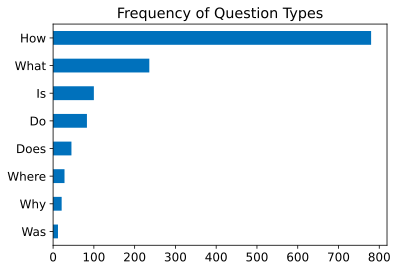

In [12]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

'How', 'What', 'Is'로 시작하는 질문이 가장 많음

In [13]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### 사이드바: 스탠포드 질문 답변 데이터셋

스탠퍼드 질문 답변 데이터 셋

- SubjQA의 형식인(질문, 리뷰, [답변])은 추출적 QA 데이터셋에서 널리 사용되는데, 스탠퍼드 질문 답변 데이터셋(Standford Question Answering Dataset)에서 처음 사용된 방식

- 시퀀스 모델이 텍스트에서 정답을 추출하는 속도가 금세 사람을 앞지름. 2019년 이후 나온 모델 대부분 사람의 능력을 뛰어 넘음

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

**그림 7-3** SQuAD 2.0 벤치마크 성능의 발전(https://paperswithcode.com에서 만든 이미지)

### 사이드바 끝

하지만 이런 초인적인 성능이 진정한 독해 능력을 나타내진 않음
답변 불가한 질문의 답은 보통 반의어 같은 텍스트에 있는 패턴을 통해 식별
- 이 문제를 해결하기 위해 구글은 자연 질문(Natural Questions(NQ) 데이터 셋을 릴리즈함
- **NQ**는 구글 검색 사용자에게서 수집한 사실 탐색 질문으로 구성되며, NQ에 있는 답변은 SQuAD에 있는 답변보다 훨씬 더 길며, 더 어려운 벤치마크를 만들어 냄

### 7.1.2 텍스트에서 답 추출하기

QA 시스템에서는 가장 먼저 고객 리뷰에 있는 텍스트에서 답변에 사용할 만한 부분을 식별해낼 방법을 찾아야 함

- 예를 들어 'Is it waterproof?'라는 질문에 'This watch is waterproof at 30m depth'라는 리뷰가 있다면 모델은 'Waterproof at 30m'를 출력해야 함

- 이를 위해서는 다음의 방법을 이해해야 함

  + 지도 학습 문제로 구성하기
  + QA작업을 위해 텍스트를 토큰화하고 인코딩하기
  + 모델의 최대 문맥 크기를 초과하는 긴 텍스트 다루기

#### 7.1.2.1 범위 분류

**범위 분류** : span classification

- 텍스트에서 답을 추출하는 가장 일반적인 방법
- 이 작업에서 모델이 예측해야 하는 레이블은 답변 범위에 해당하는 시작 토큰과 종료 토큰임


<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

추출저 QA는 레이블 구조가 데이터셋에 따라 달라지지 않기 때문에 미세 튜닝한 모델로 시작해도 무방함

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/>

이 글을 쓸 때 QA 모델은 350개가 넘음

- 이 중 어떤 모델을 선택해야 할지 결정에는 여러가지 요인이 작용함

- 주어진 말뭉치가 단일 언어인지 다중 언어인지에 따라 다르고, 제품 환경에서 모델을 실행하는 제약 조건에 따라서도 달라짐

- 아래 표에 좋은 구축 기반이 되는 모델을 정리함

|트랜스포머 | 설명| 파라미터 개수 | SQuAD 2.0에서 F1-score 점수 |
|:---|:----|:----|:----|
|MiniLM | BERT 기반 압축 버전 | 66M  | 79.5 |
|RoBERTa-base | RoBERTa 모델 기반 미세튜닝 | 125M | 83.0|
|ALBERT-XXL | 계산집약적 모델 | 235M | 88.1 |
|XLM-RoBERTa-large | 강력한 제로샷 | 570M | 83.8 |



#### 7.1.2.2 QA를 위한 텍스트 토큰화

- 이 장의 목적상 미세 튜닝한 MiniLM 모델을 사용
- 이 모델은 훈련 속도가 높아서 빠르게 반복하며 여러 기술을 확인하기 좋음
- 늘 그렇듯이 텍스트를 인코딩할 토크나이저가 가장 먼저 필요함


In [14]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

텍스트를 인코딩하기 위해 허깅페이스 허브에서 MiniLM 모델의 체크포인트를 로드함

In [15]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

모델을 작동해 보기 위해 짧은 텍스트에서 답을 추출. 추출적 QA 작업에서는 입력을 질문, 문맥 쌍 형태로 제공함

따라서 다음과 같이 두 값을 모두 토크나이저에 전달

In [16]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


파이토치 Tensor 객체가 반환되므로 이를 사용해 모델의 정방향 패스를 실행, 토큰화된 입력을 표로 확인하면 위와 같음

input_ids와 attention_mask 텐서는 익숙함

- token_type_ids 텐서는 입력에서 어떤 부분이 질문과 문맥에 해당하는지 나타냄(0은 질문 토큰, 1은 문맥 토큰을 나타냄)


In [17]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [18]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


텍스트를 토큰화했으니 QA 헤드와 함께 모델 객체를 초기화하고 입력을 정방향 패스에 통과시킴

- QA 헤드는 QuestionAnsweringModelOutput 객체를 출력함

- 헤드는 인코더의 은닉 상태를 받아 시작과 종료 범위의 로짓을 계산하는 선형 층에 해당함

- 이는 QA 작업을 4장의 개체명 인식과 비슷하게 토큰 분류 형태로 다룬다는 의미

- 출력을 답의 범위로 변환하기 위해 먼저 시작과 종료 토큰의 로짓이 필요함

In [19]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [20]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


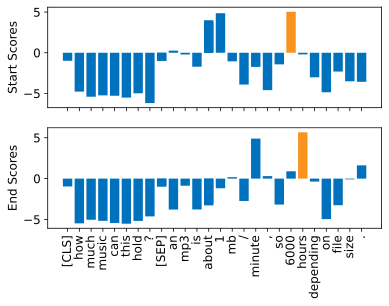

In [21]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

두 로짓(시작과 종료)은 각 입력 토큰에 연관됩니다. 위의 그림에 표현된대로 큰 양수 로짓은 가능성이 높은 시작과 종료 토큰 후보에 해당함.

이 예시에서는 모델이 숫자 1과 6,000에 가장 높은 시작 토큰 로짓을 할당함

- 질문이 어떤 양에 관한 것이므로 이해됨

- 마찬가지로 로짓이 가장 높은 종료 토큰은 'minute'과 'hours' 임


최종 답을 얻기 위해 시작 토큰과 종료 토큰의 argmax 함수를 적용하고 입력에서 이 범위를 슬라이싱함

- 다음 코드는 이런 단계를 수행하고 결과를 디코딩해 텍스트로 출력함



In [22]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


성공임! 허깅페이스 트랜스포머스는 편리하게도 이런 모든 전처리 단계와 후처리 단계가 전용 파이프라인 안에 있음. 다음처럼 토크나이저와 미세 큐닝된 모델을 전달해 파이프라인을 초기화함

In [23]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651619017124176, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082971036434174,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253506153821945,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

답변 외에도, 이 파이프라인은 (로짓에 소프트맥스 함수를 적용해) 모델이 추정한 확률을 score 필드로 제공함
- 한 문맥에서 여러 답을 비교할 때 편리함
- 또 topk 매개변수를 사용하면 모델이 여러 개의 답을 예측함
- answers.answer_start가 비어 있는 SubjAQ 샘플처럼 모델이 답변이 불가한 질문도 있음
  + 모델은 이 경우 [CLS] 토큰에 높은 시작 점수와 종료 점수를 할당
  + 파이프라인은 이 출력을 빈 문자열로 매핑함
  

In [24]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

**Note** 간단한 이 예에서는 해당 로짓에 argmax를 적용해 시작과 종료 인덱스를 얻음. 하지만 이 방법은 문맥 대신 질문에 속한 토큰을 선택해서 범위가 벗어난 답을 생성할 때도 있음. 실전에서는 범위 내에 있는지, 시작 인덱스가 종료 인덱스 앞에 있는지 등의 다양한 제약 조건을 따라 파이프 라인이 최상의 시작 인덱스와 종료 인덱스의 조합을 계산함

#### 7.1.2.3 긴 텍스트 다루기

독해 모델의 결점 하나는 종종 문맥에 있는 토큰이 모델의 최대 시퀀스 길이(보통 최대 수백개 토큰)를 초과한다는 것

  - 아래 그림을 보면 SubjQA 훈련 세트의 상당 부분이 MiniLM의 문맥 크기인 512 토큰에 맞지 않는 질문-문맥 쌍을 가짐

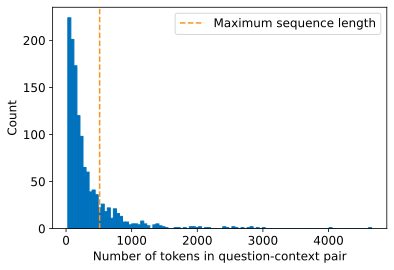

In [25]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

텍스트 분류 같은 그 외 작업에서는 정확한 예측을 생성하기 위해 [CLS] 토큰 임베딩에 충분한 정보가 담겼다고 가정하고 그냥 긴 텍스트를 자름. 하지만 QA 작업에서는 이런 전략이 문제를 일으킴. 질문의 답이 문맥의 끝에 있으면 텍스트를 잘랐을 때 답이 삭제됨

이 문제를 다루는 전형적인 방법은 아래 그림처럼 입력에 **슬라이딩 윈도**를 적용하는 것

  - 각 윈도는 모델의 문맥 크기에 맞는 토큰 리스트가 됨

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

긴 문서에서 슬라이딩 윈도가 여러 개의 질문-문맥 쌍을 만드는 방법. 첫 번째(파란색) 막대는 질문에 해당하고 두 번째(붉은색) 막대는 각 윈도에서 캡쳐한 문맥

허깅페이스 트랜스포머스는 토크나이저에 return_overflowing_tokens = True를 설정해 슬라이딩 윈도우를 생성

슬라이딩 윈도의 크기는 max_seq_length 매개변수로, 스트라이드(stride)의 크기는 doc_stride로 조절

훈련 세트에 첫 번째 샘플을 사용해 슬라이딩 윈도의 작동 방식을 확인


In [26]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

이 경우 윈도마다 input_ids의 리스트를 하나씩 얻음

각 윈도의 토큰 개수를 확인

In [27]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


마지막으로 inpud_ids를 디코딩해 두 윈도가 어디서 겹치는지 확인

In [28]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



이제 QA 모델이 텍스트에서 답을 추출하는 방법을 이해함

End-to-End QA 파이프라인을 만드는데 필요한 다른 구성 요소를 확인


### 7.1.3 헤이스택을 사용해 QA 파이프라인 구축하기

앞서 간단한 답변 추출 예제에서는 질문과 문맥을 모두 모델에 제공함
- 하지만 시스템의 실제 사용자는 제품에 대한 질문만 제공함
- 따라서 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요함

이를 수행하는 방법 중하나는 해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입하는 것
- 이 방법은 간단하지만 문맥이 극도로 길어져 때로는 사용자 쿼리에 대한 레이턴시를 수용하지 못한다는 단점이 있음
- 최신 QA 시스템은 두 가지 주요 구성 요소로 이루어진 리트리버-리더(retriever-reader) 구조를 기반으로 이 문제를 처리함

**리트리버**

쿼리에서 관련된 문서를 추출, 리트리버는 일반적으로 희소 아니면 밀집으로 구분

> 희소 리트리버
> - 희소 리트리버(sparse retriever)는 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현
> - 이 벡터의 내적(inner product)를 계산해 쿼리와 문서의 관련성을 결정


> 밀집 리트리버
> - 밀집 리트리버(dense retriever)는 트랜스포머 같은 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩(밀집 벡터)으로 표현
> - 이런 임베딩이 의미를 인코딩하므로 밀집 리트리버는 쿼리의 내용을 이해해 검색 정확도를 향상


**리더**

리트리버가 제공한 문서에서 답을 추출함

리더는 대개 독해 모델이지만 이 장의 끝에서 자유 형식의 답변을 생성하는 모델을 확인

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

**그림 7-9** 최신 QA 시스템의 리트리버-리더 아키텍처

리트리버가 추출한 문서나 리더가 추출한 답에 후처리를 적용하는 구성요소도 있음

- 예를 들어 리더에 혼동을 일으키는 잡음이나 관련 없는 요소를 제외하기 위해 추출된 문서를 다시 랭킹하는 작업을 진행함
- 마찬가지로 긴 문서에 있는 여러 구절에서 정답이 나오면 종종 리더의 답을 후처리할 필요가 있음

QA 시스템을 만들기 위해, NLP 전문 독일 기업 딥셋(deepset)(https://deepset.ai)이 개발한 헤이스택(heystack) 라이브러리 사용

- 헤이스택은 리트리버-리더 아키텍처를 기반으로 하고, 이런 시스템 구축과 관련된 많은 복잡도를 추상화하며 허깅페이스 트랜스포머스와 긴밀하게 통합됨
- 헤이스택으로 QA 파이프라인을 만들 때는 리트리버와 리더 외에 두 가지 구성 요소가 더 있음

**문서 저장소**

쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 데이터 베이스

**파이프 라인**

사용자 쿼리가 잘 흘러가도록 QA 시스템의 모든 구성 요소를 결합하고 여러 리트리버에서 추출한 문서를 합치는 등의 기능을 수행

> 이 절에서는 이런 구성요소를 사용해 프로토타입(prototype) QA 파이프라인을 빠르게 구축하는 방법을 알아봄
> **참고** 이 노트북은 pytorch 1.12.1과 haystack 1.7.0을 사용하는 버전

#### 7.1.3.1 문서 저장소 초기화하기

헤이스택에서 사용 가능한 문서 저장소는 다양하며, 저장소마다 조합할 수 있는 전용 리트리버가 있음

다음은 희소 리트리버(TF-IDF, BM25)와 밀집 리트리버(Embedding, DPR)에 각각 호환되는 문서 저장소를 정리함

|리트리버명 | 메모리 | Elasticsearch | FAISS | Milvus |
|:---------|:------|:---------------|:------|:-------|
|TF-IDF   | Yes   | Yes    | No    | No   |
|BM25     | No    | Yes    | No    | No   |
|Embedding| Yes   | Yes    | Yes   | Yes  |
|DPR      | Yes   | Yes    | Yes   | Yes  |

희소 리트리버와 밀집 리트리버를 이 장에서 모두 살펴보므로 양쪽 리트리버에 모두 호환되는 ElasticsearchDocumentStore를 사용

- **Elasticsearch**: 텍스트, 수치, 지리 데이터, 구조적 데이터, 비구조적 데이터를 포함해 다양한 데이터 타입을 처리하는 검색 엔진
  + 대용량 데이터를 저장하고 전체 텍스트(full text) 검색으로 빠르게 필터링하므로 특히 QA 시스템 개발에 잘 맞음
  + 인프라 분석을 위한 업계 표준

In [29]:
# Elastic search 설치

url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

Elastic search 서버를 시작
- 모든 코드는 주피터 노트북에서 실행하기 때문에 파이썬의 Popen() 함수를 사용해 새로운 프로세스를 시작
- 이 서브프로세스를 백그라운드에서 실행하기 위해 chown 셸 명령을 사용

In [30]:
import os
from subprocess import Popen, PIPE, STDOUT

# 백그라운드 프로세스로 일래스틱서치를 실행합니다
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

Popen() 함수에서 args로 실행할 프로그램을 지정

stdout = PIPE는 표준 출력을 위해 새로운 파이프(pipe)를 만들고 stderr = STDOUT로 지정하면 동일한 파이프로 에러가 수집됨

preexec_fn 매개변수에 사용할 서브프로세스의 아이디를 지정
기본적으로 elestic search는 포트 9200으로 로컬에서 실행됨
따라서 localhost로 HTTP 요청을 보내서 연결을 테스트 함

In [31]:
# 또는 도커가 설치되어 있다면
from haystack.utils import launch_es

launch_es()

In [32]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "1c67042a40cc",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "LPUT6U1qTt63pC3AEKQSzg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [33]:
# document_store --> document_stores
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [34]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

기본적으로 ElasticsearchDocumentStore는 elasticsearch에 두 개의 인덱스를 만듦

문서를 저장하는 document와 답의 범위를 저장하는 label

여기서 SubjQA 리뷰로 document 인덱스를 채움

헤이스택 문서 저장소를 text와 meta 키를 가진 딕셔너리의 리스트를 기대함

In [35]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")

print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


meta에 있는 필드를 사용해 검색 과정에서 필터를 적용

제품과 질문 ID로 필터링할수 있도록 SubjQA의 item_id와 id 열, 그리고 해당되는 분할 이름을 포함

다음처럼 각 DataFrame에 있는 샘플을 순회하면서 write_documents() 메서드로 인덱스에 추가

#### 7.1.3.2 리트리버 초기화하기

Elastic search 문서 저장소는 모든 헤이스택 리트리버와 조합이 가능함

>('Best Match 25'의 약자인) BM25 기반의 희소 리트리버를 사용
> - BM25는 고전적인 TF-IDF 알고리즘을 개선한 버전으로 일래스틱 서치에서 효율적으로 검색할 수 있는 희소 벡터로 질문과 문맥을 표현함
> - Bm25 점수는 검색 쿼리에서 얼마나 많은 텍스트가 일치하는지 측정
> - 그 다음 TF 값을 빠르게 포화시키고 짧은 문서가 긴 문서보다 선호되도록 문서 길이로 정규화해 TF-IDF를 개선


헤이스택 1.4에서 `ElasticsearchRetriever`가 `BM25Retriever`로 바뀌었습니다. 여전히 버전 1.5에서 `ElasticsearchRetriever`를 사용할 수 있지만 향후 버전에서 삭제될 수 있습니다.

In [36]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

훈련 세트에 있는 한 전자 제품에 대한 간단한 쿼리를 살펴봄

리뷰 기반 QA 시스템에서는 단일 아이템으로 쿼리를 제한하는 것이 중요함
- 그렇지 않으면 리트리버가 사용자 쿼리와 무관한 제품의 리뷰도 검색함

다음 아이템 ID는 아마존의 파이어 태블릿 ID 입니다. 리트리버의 retrieve() 메서드를 사용해 이 제품이 독서에 유용한지 물어보는 쿼리임
- top_k 매개변수로 얼마나 많은 문서를 반환할 지 지정하고 문서의 meta 필드에 포함시킨 item_id와 split 키에 모두 필터를 적용
- retrieved_docs의 각 원소는 문서를 나타내는데 사용하는 헤이스택의 Document 객체이고 리트리버의 쿼리 점수와 그 외 메타데이터를 포함

In [37]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [38]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to
myself.  I have been a kindle user for 4 years and this is my third one.  I
never  ...'>


문서 텍스트 외 elasticsearch가 쿼리와의 연관성을 계산한 score 필드가 출력됨 (점수가 높을 수록 매칭이 더 잘 되었음을 의미함)
내부적으로 elastic search는 인덱싱과 검색을 위해 lucene에 의존함. 따라서 기본적으로 루씬의 실용적인 스코어링 함수(practical scoring function)를 사용함
- 스코어링 함수는 elasticsearch 문서에서 자세히 설명함
- 간단히 요약하면 스코어링 함수는 불리언 텍스트(Boolean text, 이 문서가 쿼리에 매칭되는가?)를 사용하 후보 문서를 필터링한 다음 문서와 쿼리의 벡터 표현을 기반으로 유사도를 측정함

---

이제 관련된 문서를 추출할 방법이 준비되었으니 이런 문서에서 답을 추출할 방법이 필요함

- 여기에 리더가 사용되며, 헤이스택에 MiniLm 모델을 로드하는 방법을 살펴봄

#### 7.1.3.3 리더 초기화하기

헤이스택에는 주어진 문맥에서 답을 추출하는 두 종류의 리더가 있음

**FARMReader**

- 트랜스포머를 미세 튜닝하고 배포하는 딥셋의 FARM 프레임워크(https://farm.deepset.ai)를 기반으로 함
- 허깅페이스 트랜스포머스를 사용해 훈련된 모델과 호환되며 허깅페이스에서 바로 모델을 로드할 수 있음

**TransformerReader**

- 허깅페이스 트랜스포머스의 QA 파이프라인을 기반으로 함
- 추론만 실행하는데 적합

> 두 리더가 모델의 가중치를 같은 방식으로 처리하지만 예측을 변환해 답을 만드는 방식은 조금 다름
> - 허깅페이스 트랜스포머스에서 QA 파이프라인은 각 구절의 시작 로짓과 종료 로짓을 소프트맥스로 정규화함. 따라서 확률의 합이 1이 되는 같은 구절에서 추출한 답의 점수를 비교할 때만 의미 있습니다. 예를 들어 한 구절에서 점수가 0.9인 답이 다른 구절에서 0.8을 얻은 답보다 반드시 더 좋지는 않음. FARM에서는 로짓을 정규화하지 않아 구절 간의 답변이 더 쉽게 비교됨
> - TransformersReader는 이따금 같은 답을 다른 점수로 두 번 예측함. 가령 문맥이 길고 답이 중첩된 윈도에 놓인 경우 그러함. FARM에서는 이런 중복을 제거함

In [39]:
# 후반부에서 리더를 미세튜닝하기 위해 FARMReader를 사용

from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [40]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648089170455933,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293056815862656, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id':
'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


FARMReader에서 슬라이딩 윈도의 동작은 토크나이저에서 본 것과 같은 max_seq_length와 doc_stride 매개변수로 제어됨

여기서는 MiniLM 논문에 있는 값을 사용

#### 7.1.3.4 모두 합치기

헤이스택 파이프라인 중 하나를 사용해 이런 구성 요소를 모두 연결

헤이스택은 리트리버, 리더와 그 외 구성 요소를 연결해 사례에 따라 쉽게 커스터마이징 가능한 그래프로 구성하는 pipeline 추상화를 제공함

허깅페이스 트랜스포머스에 있는 파이프라인과 비슷하지만 QA 시스템에 특화된 사전 정의된 파이프라인도 있음
- 이 경우 답 추출에 관심이 있으므로 매개변수로 하나의 리트리버-리더 쌍을 받는 ExtractiveQAPipeline을 사용

In [41]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

각 Pipeline은 쿼리가 어떻게 실행되어야 하는지 지정하는 run() 메서드가 있음
ExtractiveQAPipeline의 경우 query, top_k_retriever로 추출할 문서 개수, top_k_reader로 문서에서 추출할 답 개수를 전달함

이 경우 아이템 ID에 대한 필터도 지정해야 함

이는 앞서 리트리버에서 한 것처럼 filters 매개변수를 사용해 처리


In [42]:
n_answers = 3
preds = pipe.run(query=query,
                 params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}},
                                      "Reader": {"top_k": n_answers}})

print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx].answer}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx].context}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...



답변 2: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 3:
해당 리뷰 텍스트: ...None...





아마존 파이어 태블릿에 대한 질문 예를 다시 실행한 결과

이번에는 추출된 답을 반환함

성능을 더 높이려면 리트리버와 리더의 성능을 정량화할 지표가 필요함

## 7.2 QA 파이프라인 개선하기

### 7.2.1 리트리버 평가하기

리트리버를 평가하는 일반적인 지표 하나는 추출된 관련 문서의 비율을 측정하는 **재현율(recall)**임
- 일련의 질문이 주어지면 리트리버가 반환한 최상위 k개 문서에 답이 등장한 횟수를 카운트해 재현율을 계산함
- 헤이스택에서 리트리버를 평가하는 방법은 두 가지임
  + 리트리버가 제공하는 eval() 메서드 사용
  + EvalDocuments 클래스와 리트리버를 결합하는 사용자 정의 Pipeline 만듦. 이를 통해 사용자 정의 지표와 쿼리 흐름을 구현함

**NOTE** 재현율을 보완하는 지표는 mAP(Mean Average Precision)임. 문서 순위에서 정답을 높은 위치에 놓은 리트리버에 보상을 제공



In [43]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [44]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가합니다
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가합니다
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [45]:
print(labels[0])

<Label: {'id': 'ba11694e-5f62-4097-952c-e91414e8d98b', 'query': 'What is the
tonal balance of these headphones?', 'document': {'content': "I have been a
headphone fanatic for thirty years and have owned and used a variety of
headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.
The Sony MDRV6 excells as the best value of any headphone that I've ever owned.
They are especially good at producing natural-sounding deep bass, and the
overall octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the velour pads from BeyerDynamic.  The pads tha

질문 답변 쌍과 쿼리마다 문서 저장소를 필터링할 수 있는 고유한 질문 ID가 담긴 origin 필드가 있음. 또 제품으로 레이블을 필터링하기 위해 meta 필드에 제품 ID를 추가함.
레이블이 준비되었으니 다음처럼 elastic search의 label 인덱스에 저장함

In [46]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

455개의 질문 답변 쌍을 로드했습니다.


다음으로 파이프라인에 전달하기 위해 질문 ID와 이에 상응하는 답변을 매핑함. 전체 레이블을 얻기 위해 문서 저장소의 get_all labels aggreated() 메서드를 사용해 고유 ID를 가진 모든 질문-답변 쌍을 가져옴

이 메서드는 Multilabel 객체의 리스트를 반환함
하지만 이 예제에서는 질문 ID로 필터링하기 때문에 하나의 원소만 반환됨
다음 코드를 실행하면 레이블의 리스트를 생성함

In [47]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [48]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': '899973d8-a5e4-4ab8-85b3-7b9203eb8ea8', 'query':
'How does the fan work?', 'document': {'content': 'the usb on the back caused my
mac to restart when i would plug something into about 50% of the time.  very
annoying but the fan is really really good!', 'content_type': 'text', 'id':
'a5db4d52bb4d0fcadff2b8a6f4e54d75', 'meta': {}, 'score': None, 'embedding':
None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin':
'gold-label', 'answer': {'answer': 'the fan is really really good', 'type':
'extractive', 'score': None, 'context': None, 'offsets_in_document': None,
'offsets_in_context': None, 'document_id': None, 'meta': {}}, 'no_answer':
False, 'pipeline_id': None, 'created_at': '2024-01-25 12:12:17', 'updated_at':
'2024-01-25 12:12:17', 'meta': {'item_id': 'B002MU1ZRS', 'question_id':
'5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS'],
'split': ['test']}}, {'id': 'de1ac186-18be-4610-8827-f2b0538a6648', 'query':
'How d

레이블 하나를 살펴보면 질문 하나에 연관된 모든 답이 multiple_answers 필드에 들어 있음

In [49]:
# 다음처럼 원하는 top_k 값으로 파이프라인을 실행할 수 있습니다
eval_result = pipe.eval(
     labels=labels_agg,
     params={"Retriever": {"top_k": 3}},
 )

metrics = eval_result.calculate_metrics()

In [50]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

재현율@3: 0.96


성공임! 추출한 문서 개수를 위해 top_k_retriever에 특정 값을 지정함. 일반적으로 이 매개변수를 증가시키면 재현율이 향상되지만 리더에 더 많은 문서를 제공하는 대가로 엔드-투-엔드 파이프라인은 느려짐. 어떤 값을 선택할 지 결정할 때 도움이 되도록 몇 개의 k 값을 반복하고 각 k에서 전체 테스트 세트의 재현율을 계산하는 함수를 만들어 봄

In [51]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

,query,filters,rank,document_id,gold_document_ids,gold_id_match
0,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
1,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
0,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,9cae133919a2dc476c371cde9e5effb8,[],0.0
1,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,a1f6e39766a79f1475b3dbe07e517e04,[],0.0
2,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,0fc71a2e4ec350e845ed384717792ad8,[],0.0
0,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]",1.0


In [52]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # 최대 top_k를 계산합니다
    max_top_k = max(topk_values)
    # 파이프라인을 만듭니다
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하면서 최대 top_k로 추론을 실행합니다
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # 각 top_k 값에 대해 재현율을 계산합니다
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

결과를 그래프로 그려 k가 증가함에 따라 재현율이 어떻게 향상되는지 확인

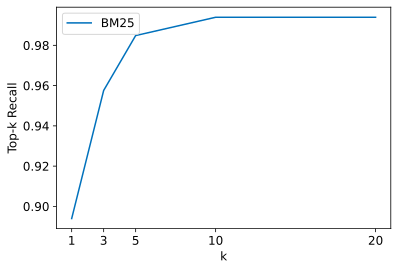

In [53]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

그래프를 보면 k=5에서 변곡점이 있고 k=10부터 거의 완벽한 재현율을 달성함. 그럼 이제 밀집 벡터 기법으로 추출한 문서를 확인

#### 7.2.1.1 DPR (Dense Passage Retrieval)

희소 리트리버는 k=10개 문서를 반환할 때 거의 완벽한 재현율을 달성함.

하지만 k값이 그보다 작을 때 성능을 높일 수 있는 방법은?
- 희망적인 대안은 밀집 임베딩을 사용해 질문과 문서를 표현하는 것
- DPR(Dense Passage Retrieval)이라 불리는 구조가 현재 최고의 성능을 달성함
- DPR은 두 개의 BERT 모델을 사용해 질문과 구절을 인코딩한다는 개념에 기반함

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

**그림 7-10** 문서와 쿼리의 관련성을 계산하기 위한 DPR의 이중 인코더 구조

입력 텍스트를 [CLS] 토큰의 d차원 벡터 표현으로 매핑함

헤이스택에서 DPR을 위한 리트리버를 만드는 방법은 BM25 방법과 비슷함

문서 저장소를 지정하고, 질문과 구절을 위한 BERT 인코더를 선택함. 선택한 인코더에 관련된 구절(양성)과 무관한 구절(음성)을 질문과 함께 주입해 훈련함

연관된 질문-구절 쌍이 높은 유사도를 가지도록 학습하는 것이 목표임

이 예제에서는 NQ 말뭉치에서 미세 튜닝한 인코더를 사용

In [54]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

제품으로 필터링하므로 문서 제목(item_id)을 연결해 추가 정보를 얻지 못하기 때문에 embed_title = False로 지정

밀집 리트리버를 초기화한 후 다음 단계로 elastic search에 인덱스된 문서를 모두 순회하면서 인코더를 적용해 임베딩 표현을 업데이트함

In [55]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

이제 모두 준비됨! BM25와 같은 방식으로 밀집 리트리버를 평가하고 탑-k 재현율을 비교함

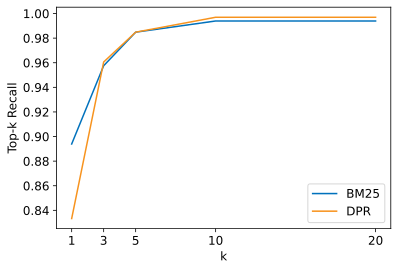

In [56]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

그래프를 보면 DPR은 재현율이 k=3 근방에서 교차하는 모습을 확인할 수 있음

### 7.2.2 리더 평가하기

추출적 QA에서 리더를 평가하는 주요 지표는 두 가지

**EM(Exact Match)**

- 예측과 정답에 있는 문자가 정확히 일치하면 EM=1이고 그렇지 않으면 EM=0인 이진 지표
- 답이 없다고 예상되면 텍스트를 전혀 예측하지 못하는 것처럼 모델은 EM=0을 받음

**F1-점수**

- 정밀도와 재현율의 조화평균을 측정

FARM에서 헬퍼 함수를 임포트하고 간단한 샘플을 적용해 이런 지표의 작동 방식을 확인함

In [57]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


내부적으로 이 함수들은 구두점 삭제, 공백 수정, 소문자 변환을 적용해 먼저 예측과 레이블을 정규화함.

그 다음 정규화된 문자열을 BoW로 토큰화함.

마지막으로 토큰 수준에서 측정 지표를 계산함

앞의 간단한 샘플을 통해 EM이 F1-점수보다 훨씬 더 엄격한 지표임을 확인함

In [58]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


하지만 F1-점수에만 의존하면 결과가 왜곡될 가능성이 존재함. 따라서 두 지표를 모두 참고해 모델 성능의 과소평가(EM)와 과대평가(F1-점수) 사이에서 균형을 잡는 게 좋은 전략

보통 질문에는 유효한 답이 여러개 있음. 따라서 평가 세트에 있는 각각의 질문-답 쌍에 대해 이런 지표를 계산하고 가능한 답 중에서 가장 좋은 점수를 선택함. 그 다음 각각의 질문-답 쌍의 개별 점수를 평균해 모델의 전체적인 EM과 F1-점수를 구함

리더를 평가하기 위해 노드가 두 개(리더 노드와 리더를 평가할 노드)인 새로운 파이프라인을 만들어야 함. 리더의 예측을 받아 EM과 F1-점수를 계산하는 EvalAnswers 클래스를 사용. SQuAD 평가와 비교하기 위해 EvalAnswers에 저장된 top_1_em 과 top_1_f1 점수로 쿼리마다 최상의 답을 선택함

In [66]:
from haystack.pipelines import Pipeline

def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}



In [64]:
'''
def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

    i = 0
    for l in labels_agg:
        doc = document_store.query(l.question,
                                   filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)
        i += 1
        sleep(0.01)  # 쿼리 속도를 조절하기 위해

    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}
'''

In [65]:
reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

NameError: name 'EvalAnswers' is not defined

skip_incorrect_retrieval=False로 지정한 것을 눈여겨 볼 것.
(SQuAD 평가에서처럼) 리트리버가 항상 리더에 문맥을 전달하도록 만듦
이제 모든 질문에서 리더를 실행했으니 점수를 출력

TypeError: no numeric data to plot

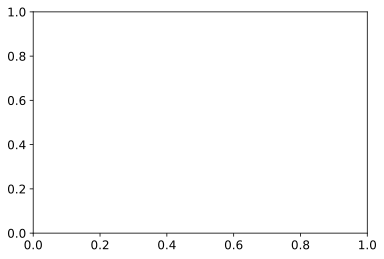

In [62]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### 7.2.3 도메인 적응

SQuAD에서 미세 튜닝한 모델은 대개 다른 도메인에 잘 일반화되지만, SubjQA에서 모델의 EM과 F1-점수는 SQuAD보다 훨씬 더 않좋음. 이런 일반화 실패는 다른 추출적 QA데이터셋에서도 관찰했는데, 이는 트랜스포머 모델이 SQuAD 데이터셋에 과대적합된 증거로 생각됨.

- 리더의 성능을 가장 쉽게 향상하는 방법은 MiniLM 모델을 SubjQA 훈련 세트에서 미세 튜닝하는 것
- 이를 위해 FARMReader는 train() 메서드를 제공
- 이 메서드는 SQuAD JSON 포맷으로 데이터를 입력받음


<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

**그림7-11** SQuAD JSON 포맷

아이템 마다 질문-답 쌍을 모두 합친 포맷임

데이터 포맷이 매우 복잡하니 판다스를 사용해 변환

먼저, 각 제품 ID에 연관된 paragraphs 배열을 만드는 함수를 구현.

이 배열의 원소는 하나의 문맥(즉, 리뷰)과 질문-답 쌍의 배열인 qas들 담고 있음


In [67]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍을 필터링합니다
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas 배열을 만듭니다
        for qid, question in id2question.items():
            # 하나의 질문 ID에 대해 필터링합니다
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # 답변 가능한 질문을 추가합니다
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas에 추가합니다
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # 문맥과 질문-답 쌍을 paragraphs에 추가합니다
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

하나의 제품 ID에 연관된 DataFrame의 열을 전달해 SQuAD 포맷을 만듬

In [68]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

마지막으로 이 함수를 각 분할의 DataFrame에 있는 모든 제품 ID에 적용

다음 convert_to_squad 함수는 이 과정을 수행. 그 결과를 electronics-{split}.json 파일에 저장

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [69]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID에 대해 `paragraphs`를 만듭니다
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # 결과를 디스크에 저장합니다
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

이제 적절한 포맷으로 분할세트를 준비하였으니, 훈련과 개발 분할의 위치와 미세 튜닝한 모델을 저장할 위치를 지정해 리더를 미세 튜닝함

In [71]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json:   0%|          | 0/1265 [09:42<?, ? Dicts/s]


KeyboardInterrupt: 

미세 튜닝된 리더의 테스트 세트 성능을 기준 모델과 비교

In [72]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

KeyboardInterrupt: 

사전 훈련된 언어 모델을 바로 SubjQA 훈련 세트에 미세 튜닝하지 않는 이유
- 과대적합 발생 위험 때문에

그럼에도 공정한 비교를 위해 SQuAD에서 기준 모델을 미세 튜닝할 때 사용한 언어 모델을 그대로 사용
이전처럼 FARMReader로 모델을 로드함

In [73]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

한 에포크 동안 미세 튜닝함

In [74]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing Dataset electronics-train.json:   0%|          | 0/1265 [00:20<?, ? Dicts/s]


KeyboardInterrupt: 

테스트 세트에서 평가해 이전 결과와 비교

In [75]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

KeyboardInterrupt: 

SubjQA에서 바로 미세 튜닝한 언어 모델은 SQuAD와 SubjQA에서 미세 튜닝한 모델보다 성능이 크게 떨어짐

**Warning** 작은 데이터 셋을 다룰 때 과대적합하기 쉬운 트랜스포머 모델을 평가하려면 교차 검증을 사용하는 것이 좋음. SQuAD 포맷의 데이터셋으로 교차 검증을 수행하는 방법은 FARM 저장소에 있는 예제 참고

### 7.2.4 전체 QA 파이프라인 평가하기

리더와 리트리버를 개별적으로 평가하는 방법을 알았으니 이를 연결해 파이프라인의 전체 성능을 평가

이를 위해 리트리버 파이프라인에 리더와 리더의 평가노드를 추가


In [76]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# 평가하기!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표를 추출합니다
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

Exception: Exception while running node `Retriever` with input `{'_debug': {'Query': {'input': {'debug': True}, 'output': {}}}, 'root_node': 'Query', 'params': {'filters': {'item_id': ['B00001WRSJ'], 'split': ['test']}, 'Query': {}, 'Retriever': {'debug': True}}, 'query': 'What is the tonal balance of these headphones?', 'labels': <MultiLabel: {'labels': [{'id': 'ba11694e-5f62-4097-952c-e91414e8d98b', 'query': 'What is the tonal balance of these headphones?', 'document': {'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone.  This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable.  I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair.  The thin cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally  slide under the inner circumference of the pad, which is considerably more comfortable.  I can recommend this trivial modification without reservation to anyone who owns these headphones.  Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface.", 'content_type': 'text', 'id': 'f011c75fb8d26066217e64b3ff470d84', 'meta': {}, 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'I have been a headphone fanatic for thirty years', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_id': None, 'meta': {}}, 'no_answer': False, 'pipeline_id': None, 'created_at': '2024-01-25 12:12:16', 'updated_at': '2024-01-25 12:12:16', 'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'}, 'filters': {'item_id': ['B00001WRSJ'], 'split': ['test']}}], 'query': 'What is the tonal balance of these headphones?', 'answers': ['I have been a headphone fanatic for thirty years'], 'no_answer': False, 'document_ids': ['f011c75fb8d26066217e64b3ff470d84'], 'contexts': ["I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone.  This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable.  I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair.  The thin cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally  slide under the inner circumference of the pad, which is considerably more comfortable.  I can recommend this trivial modification without reservation to anyone who owns these headphones.  Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface."], 'offsets_in_contexts': [], 'offsets_in_documents': []}>, 'node_id': 'Retriever'}`: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e54e0>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e54e0>: Failed to establish a new connection: [Errno 111] Connection refused), full stack trace: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 245, in perform_request
    response = self.pool.urlopen(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 799, in urlopen
    retries = retries.increment(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/retry.py", line 525, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/packages/six.py", line 770, in reraise
    raise value
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 416, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 244, in request
    super(HTTPConnection, self).request(method, url, body=body, headers=headers)
  File "/usr/lib/python3.10/http/client.py", line 1283, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1329, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1278, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1038, in _send_output
    self.send(msg)
  File "/usr/lib/python3.10/http/client.py", line 976, in send
    self.connect()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 205, in connect
    conn = self._new_conn()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 186, in _new_conn
    raise NewConnectionError(
urllib3.exceptions.NewConnectionError: <urllib3.connection.HTTPConnection object at 0x7ef5096e54e0>: Failed to establish a new connection: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 512, in run
    node_output, stream_id = self._run_node(node_id, node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 439, in _run_node
    return self.graph.nodes[node_id]["component"]._dispatch_run(**node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 201, in _dispatch_run
    return self._dispatch_run_general(self.run, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 245, in _dispatch_run_general
    output, stream = run_method(**run_inputs, **run_params)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 278, in run
    output, stream = run_query_timed(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 109, in wrapper
    ret = fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 327, in run_query
    documents = self.retrieve(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/sparse.py", line 204, in retrieve
    documents = self.document_store.query(
  File "/usr/local/lib/python3.10/dist-packages/haystack/document_stores/elasticsearch.py", line 890, in query
    result = self.client.search(index=index, body=body, headers=headers)["hits"]["hits"]
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/utils.py", line 152, in _wrapped
    return func(*args, params=params, headers=headers, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/__init__.py", line 1658, in search
    return self.transport.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 390, in perform_request
    raise e
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 358, in perform_request
    status, headers_response, data = connection.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 258, in perform_request
    raise ConnectionError("N/A", str(e), e)
elasticsearch.exceptions.ConnectionError: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e54e0>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e54e0>: Failed to establish a new connection: [Errno 111] Connection refused)


In [77]:
# 리더와 전체 QA 파이프라인의 EM과 F1-점수 비교
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

KeyError: 'Fine-tune on SQuAD + SubjQA'

In [78]:
# 또는 QA 파이프라인과 리더 지표를 한번에 얻습니다
# 리더 평가는 시뮬레이트된 완벽한 리트리버 결과를 사용해 두 번째로 실행됩니다
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 시뮬레이트된 완벽한 리트리버로 격리되어 실행된 리더로부터 지표를 추출합니다
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

Exception: Exception while running node `Retriever` with input `{'_debug': {'Query': {'input': {'debug': True}, 'output': {}}}, 'root_node': 'Query', 'params': {'add_isolated_node_eval': True, 'filters': {'item_id': ['B00001WRSJ'], 'split': ['test']}, 'Query': {}, 'Retriever': {'debug': True}}, 'query': 'What is the tonal balance of these headphones?', 'labels': <MultiLabel: {'labels': [{'id': 'ba11694e-5f62-4097-952c-e91414e8d98b', 'query': 'What is the tonal balance of these headphones?', 'document': {'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone.  This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable.  I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair.  The thin cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally  slide under the inner circumference of the pad, which is considerably more comfortable.  I can recommend this trivial modification without reservation to anyone who owns these headphones.  Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface.", 'content_type': 'text', 'id': 'f011c75fb8d26066217e64b3ff470d84', 'meta': {}, 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'I have been a headphone fanatic for thirty years', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_id': None, 'meta': {}}, 'no_answer': False, 'pipeline_id': None, 'created_at': '2024-01-25 12:12:16', 'updated_at': '2024-01-25 12:12:16', 'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'}, 'filters': {'item_id': ['B00001WRSJ'], 'split': ['test']}}], 'query': 'What is the tonal balance of these headphones?', 'answers': ['I have been a headphone fanatic for thirty years'], 'no_answer': False, 'document_ids': ['f011c75fb8d26066217e64b3ff470d84'], 'contexts': ["I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face of the headphone.  This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable.  I read on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair.  The thin cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally  slide under the inner circumference of the pad, which is considerably more comfortable.  I can recommend this trivial modification without reservation to anyone who owns these headphones.  Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface."], 'offsets_in_contexts': [], 'offsets_in_documents': []}>, 'node_id': 'Retriever'}`: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e4f40>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e4f40>: Failed to establish a new connection: [Errno 111] Connection refused), full stack trace: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 245, in perform_request
    response = self.pool.urlopen(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 799, in urlopen
    retries = retries.increment(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/retry.py", line 525, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/packages/six.py", line 770, in reraise
    raise value
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 416, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 244, in request
    super(HTTPConnection, self).request(method, url, body=body, headers=headers)
  File "/usr/lib/python3.10/http/client.py", line 1283, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1329, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1278, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1038, in _send_output
    self.send(msg)
  File "/usr/lib/python3.10/http/client.py", line 976, in send
    self.connect()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 205, in connect
    conn = self._new_conn()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 186, in _new_conn
    raise NewConnectionError(
urllib3.exceptions.NewConnectionError: <urllib3.connection.HTTPConnection object at 0x7ef5096e4f40>: Failed to establish a new connection: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 512, in run
    node_output, stream_id = self._run_node(node_id, node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 439, in _run_node
    return self.graph.nodes[node_id]["component"]._dispatch_run(**node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 201, in _dispatch_run
    return self._dispatch_run_general(self.run, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 245, in _dispatch_run_general
    output, stream = run_method(**run_inputs, **run_params)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 278, in run
    output, stream = run_query_timed(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 109, in wrapper
    ret = fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 327, in run_query
    documents = self.retrieve(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/sparse.py", line 204, in retrieve
    documents = self.document_store.query(
  File "/usr/local/lib/python3.10/dist-packages/haystack/document_stores/elasticsearch.py", line 890, in query
    result = self.client.search(index=index, body=body, headers=headers)["hits"]["hits"]
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/utils.py", line 152, in _wrapped
    return func(*args, params=params, headers=headers, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/__init__.py", line 1658, in search
    return self.transport.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 390, in perform_request
    raise e
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 358, in perform_request
    status, headers_response, data = connection.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 258, in perform_request
    raise ConnectionError("N/A", str(e), e)
elasticsearch.exceptions.ConnectionError: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e4f40>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5096e4f40>: Failed to establish a new connection: [Errno 111] Connection refused)


리트리버가 반환한 문서에서 정답을 예측하는 모델의 탑-1 EM과 탑-1 F1 점수를 비교

이 그래프에서 리트리버가 전체 성능에 미치는 영향을 볼 수 있음

SQuAD 스타일의 평가에서와 같이 질문-문맥 쌍을 매칭하는 것에 비해 전체적으로 감소됨.

이 문제는 리더가 예측하는 답변의 개수를 증가시켜 피할 수 있음

지금까지 문맥에서만 답 범위를 추출했지만 보통 답은 문서 전체에 흩어져 있음
- 이럴 때는 모델이 조각을 모아 일관된 하나의 답으로 합성해야 함
- 이런 작업을 위해 생성적 QA(generative QA)를 사용하는 방법 확인 필요

## 7.3 추출적 QA를 넘어서

문서에서 텍스트 범위로 답을 추출하는 것의 흥미로운 대안은 사전 훈련된 언어 모델로 답을 생성하는 것
이런 방법을 종종 추상적 QA(abstractive QA) 또는 생성적 QA(generative QA)라고 함
여러 구절에 흩어진 증거를 합성해 더 나은 문장으로 답을 구성함. 추출적 QA보다 더 성숙하진 않지만 빠르게 성장하는 연구 분야임

이 절에서는 현재 최고의 성능을 내는 RAG(retrieval-augmented generation)에 대해 간단히 살펴봄

RAG는 이 장에서 살펴본 고전적인 리트리버-리더 구조를 확장함

리더를 제너레이터로 바꾸고 리트리버로 DPR을 사용함
제너레이터는 T5나 BART 같은 사전 훈련 기반으로 답변을 반복적으로 생성함
DPR과 제너레이터가 미분 가능하기 때문에 아래 그림 처럼 전체 과정을 엔드-투-엔드로 미세 튜닝할 수 있음

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_rag-architecture.png?raw=1" id="rag"/>


**그림7-13** 리트리버와 제너레이터를 엔드-투-엔드로 미세 튜닝하기 위한 RAG 아키텍처(Ethan Perez 제공)

RAG를 구동하기 위해 앞에서 만든 dpr_retriever를 사용

따라서 제너레이터만 만들면 됨. 이 때 선택 가능한 RAG 모델은 두 종류

**RAG-시퀀스**

- 하나의 추출 문서를 사용해 완전한 답을 생성함. 특히 리트리버가 반환한 탑-k개 문서를 제너레이터에 주입해 각 문서에서 출력 시퀀스를 만들고 이 결과를 합쳐(marginalize) 최선의 답을 얻음

**RAG-토큰**

여러 문서를 사용해 답에 있는 각 토큰을 생성함. 제너레이터가 여러 문서에서 단서를 찾아 합성

RAG-토큰 모델이 RAG-시퀀스 보다 성능이 더 좋으니 NQ에서 미세튜닝한 토큰 모델을 제너레이터로 사용. 헤이스택에서 제너레이터를 초기화하는 것은 리더를 초기화는 것과 비슷함.

하지만 문맥 위를 슬라이딩하는 윈도를 위해 max_seq_length와 doc_stride 매개변수를 지정하는 대신 텍스트 생성을 제어하는 하이퍼파라미터를 지정함

In [79]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

num_beams는 빔 서치에 사용할 빔 크기를 지정. 말뭉치를 항상 제품 ID로 필터링하기 때문에 DPR 리트리버에서 했던 것처럼 문서 제목을 임베딩하지 않음

다음 작업으로 헤이스택의 GenerativeQAPipeline을 사용해 리트리버와 제너레이터를 연결함

**NOTE** RAG에서 쿼리 인코더와 제너레이터는 모두 엔드-투-엔드로 훈련됨. 반면 문맥 인코더는 동결. 헤이스택에서 GenerativeQAPipeline은 RAGenerator의 쿼리 인코더와 DensePassangeRetrierver의 문맥 인코더를 사용함

이전처럼 아마존 파이어 태블릿에 대한 쿼리를 주입해 RAG를 실행. 이를 위해 쿼리를 받고 최상의 답을 출력하는 간단한 함수를 생성

In [80]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [81]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k":5,
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})
    print(f"질문: {preds['query']} \n")
    for idx in range(top_k_generator):
        # print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
        print(f"답변 {idx+1}: {preds['answers'][idx].answer}")

테스트 준비 완료!

In [82]:
generate_answers(query)

Exception: Exception while running node `Retriever` with input `{'root_node': 'Query', 'params': {'Retriever': {'top_k': 5, 'filters': {'item_id': ['B0074BW614']}}, 'Generator': {'top_k': 3}}, 'query': 'Is it good for reading?', 'node_id': 'Retriever'}`: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef464249f00>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef464249f00>: Failed to establish a new connection: [Errno 111] Connection refused), full stack trace: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 245, in perform_request
    response = self.pool.urlopen(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 799, in urlopen
    retries = retries.increment(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/retry.py", line 525, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/packages/six.py", line 770, in reraise
    raise value
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 416, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 244, in request
    super(HTTPConnection, self).request(method, url, body=body, headers=headers)
  File "/usr/lib/python3.10/http/client.py", line 1283, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1329, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1278, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1038, in _send_output
    self.send(msg)
  File "/usr/lib/python3.10/http/client.py", line 976, in send
    self.connect()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 205, in connect
    conn = self._new_conn()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 186, in _new_conn
    raise NewConnectionError(
urllib3.exceptions.NewConnectionError: <urllib3.connection.HTTPConnection object at 0x7ef464249f00>: Failed to establish a new connection: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 512, in run
    node_output, stream_id = self._run_node(node_id, node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 439, in _run_node
    return self.graph.nodes[node_id]["component"]._dispatch_run(**node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 201, in _dispatch_run
    return self._dispatch_run_general(self.run, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 245, in _dispatch_run_general
    output, stream = run_method(**run_inputs, **run_params)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 278, in run
    output, stream = run_query_timed(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 109, in wrapper
    ret = fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 327, in run_query
    documents = self.retrieve(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/dense.py", line 304, in retrieve
    documents = self.document_store.query_by_embedding(
  File "/usr/local/lib/python3.10/dist-packages/haystack/document_stores/elasticsearch.py", line 1228, in query_by_embedding
    result = self.client.search(index=index, body=body, request_timeout=300, headers=headers)["hits"]["hits"]
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/utils.py", line 152, in _wrapped
    return func(*args, params=params, headers=headers, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/__init__.py", line 1658, in search
    return self.transport.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 390, in perform_request
    raise e
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 358, in perform_request
    status, headers_response, data = connection.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 258, in perform_request
    raise ConnectionError("N/A", str(e), e)
elasticsearch.exceptions.ConnectionError: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef464249f00>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef464249f00>: Failed to establish a new connection: [Errno 111] Connection refused)


이 결과는 나쁜 답은 아니지만 질문의 주관적인 특징이 제너레이터를 혼동시킴. 조금 더 사실에 관한 질문을 던져 봄

In [83]:
generate_answers("What is the main drawback?")

Exception: Exception while running node `Retriever` with input `{'root_node': 'Query', 'params': {'Retriever': {'top_k': 5, 'filters': {'item_id': ['B0074BW614']}}, 'Generator': {'top_k': 3}}, 'query': 'What is the main drawback?', 'node_id': 'Retriever'}`: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5094ec490>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5094ec490>: Failed to establish a new connection: [Errno 111] Connection refused), full stack trace: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 245, in perform_request
    response = self.pool.urlopen(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 799, in urlopen
    retries = retries.increment(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/retry.py", line 525, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/packages/six.py", line 770, in reraise
    raise value
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 416, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 244, in request
    super(HTTPConnection, self).request(method, url, body=body, headers=headers)
  File "/usr/lib/python3.10/http/client.py", line 1283, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1329, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1278, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.10/http/client.py", line 1038, in _send_output
    self.send(msg)
  File "/usr/lib/python3.10/http/client.py", line 976, in send
    self.connect()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 205, in connect
    conn = self._new_conn()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 186, in _new_conn
    raise NewConnectionError(
urllib3.exceptions.NewConnectionError: <urllib3.connection.HTTPConnection object at 0x7ef5094ec490>: Failed to establish a new connection: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 512, in run
    node_output, stream_id = self._run_node(node_id, node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/pipelines/base.py", line 439, in _run_node
    return self.graph.nodes[node_id]["component"]._dispatch_run(**node_input)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 201, in _dispatch_run
    return self._dispatch_run_general(self.run, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/base.py", line 245, in _dispatch_run_general
    output, stream = run_method(**run_inputs, **run_params)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 278, in run
    output, stream = run_query_timed(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 109, in wrapper
    ret = fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/base.py", line 327, in run_query
    documents = self.retrieve(
  File "/usr/local/lib/python3.10/dist-packages/haystack/nodes/retriever/dense.py", line 304, in retrieve
    documents = self.document_store.query_by_embedding(
  File "/usr/local/lib/python3.10/dist-packages/haystack/document_stores/elasticsearch.py", line 1228, in query_by_embedding
    result = self.client.search(index=index, body=body, request_timeout=300, headers=headers)["hits"]["hits"]
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/utils.py", line 152, in _wrapped
    return func(*args, params=params, headers=headers, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/client/__init__.py", line 1658, in search
    return self.transport.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 390, in perform_request
    raise e
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/transport.py", line 358, in perform_request
    status, headers_response, data = connection.perform_request(
  File "/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/http_urllib3.py", line 258, in perform_request
    raise ConnectionError("N/A", str(e), e)
elasticsearch.exceptions.ConnectionError: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5094ec490>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7ef5094ec490>: Failed to establish a new connection: [Errno 111] Connection refused)


SubjQA에서 엔드-투-엔드로 RAG를 미세튜닝하면 더 좋은 결과를 얻음.

## 7.4 결론

앞으로 텍스트, 표, 이미지 같은 여러 형태를 아우르는 멀티모달 QA(multimodal QA)가 흥미로운 연구 분야로 자리 잡을 것으로 예상됨

전도 유망한 또 다른 분야는 레이블링되지 않은 데이터나 데이터 증식(data augmentation)을 사용해 비지도 또는 약 지도 훈려의 형태로 수행되는 자동 질문 생성(automatic question generation)

- PAQ(Probably Answered Questions) 벤치마크와 교차 언어 설정을 위한 합성 데이터 증식에 관한 논문이 발표되고 있음

다음 장에서는 모델 예측의 속도를 더 높이는 방법을 살펴보고자 함

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-pyramid.png?raw=1" id="qa-pyramid"/>

**그림 7-14** QA 요구계층